In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

In [0]:
# automatically reload external modules if they change
%load_ext autoreload
%autoreload 2

import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torch.autograd import Variable
from tqdm import tqdm

In [0]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [0]:
# Define constants
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 8
latent_dim = 100
sample_interval = 400
img_size = 28
channels = 1
img_shape = (channels, img_size, img_size)
n_critic = 5
clip_value = 0.01
lambda_gp = 10
device = 'cuda'
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [0]:
# Original WGAN-GP (from Pytorch-GAN: https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [0]:
# from same source stated above
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [0]:
#original mnist dataset
mnist = MNIST("../../data", train=True, download=True, 
              transform=transforms.Compose(
              [transforms.ToTensor(), transforms.Normalize([0.5], [0.5], inplace=False)]))
fmnist = FashionMNIST("../../data", train=True, download=True, 
              transform=transforms.Compose(
              [transforms.ToTensor(), transforms.Normalize([0.5], [0.5], inplace=False)]))

0it [00:00, ?it/s]

9920512it [00:02, 4509186.22it/s]                             


Extracting ../../data/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 67474.64it/s]                            
0it [00:00, ?it/s]

Extracting ../../data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:01, 1124715.23it/s]                            
0it [00:00, ?it/s]

Extracting ../../data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 25616.02it/s]            
0it [00:00, ?it/s]

Extracting ../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


26427392it [00:04, 6556804.40it/s]                              


Extracting ../../data/FashionMNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

32768it [00:00, 37879.84it/s]                           
0it [00:00, ?it/s]

Extracting ../../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:02, 1899289.97it/s]                            
0it [00:00, ?it/s]

Extracting ../../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 16565.03it/s]            

Extracting ../../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
#block pixels & block patches function
def block_pixels(imgs, p):
    p_mask = torch.full(imgs.size(), p)
    mask = torch.bernoulli(p_mask).to(torch.bool)
    bp_imgs = imgs.clone()
    bp_imgs[mask] = 0
    return(bp_imgs)
  
def block_patches(imgs, patch_size = 10):
    top = torch.randint(low = 0, high = imgs.size(-1) - patch_size, size = (imgs.size(0),))
    left = torch.randint(low = 0, high = imgs.size(-1) - patch_size, size = (imgs.size(0),))
    bottom = top + patch_size
    right = left + patch_size
    
    bp_imgs = imgs.clone()
    if bp_imgs.dim == 3:  
        for i in tqdm(range(bp_imgs.size(0))):
            bp_imgs[i][top[i]:bottom[i], left[i]:right[i]] = 0
    if bp_imgs.dim == 4:
        for i in tqdm(range(bp_imgs.size(0))):
            bp_imgs[i][0][top[i]:bottom[i], left[i]:right[i]] = 0
    return(bp_imgs)

In [0]:
# create lossy datasets
bp_mnist = (block_pixels(mnist.data, 0.3).to(torch.float)/255 - 0.5)/0.5

In [0]:
bp_fmnist = (block_patches(fmnist.data).to(torch.float)/255 - 0.5)/0.5

100%|██████████| 60000/60000 [00:01<00:00, 44088.64it/s]


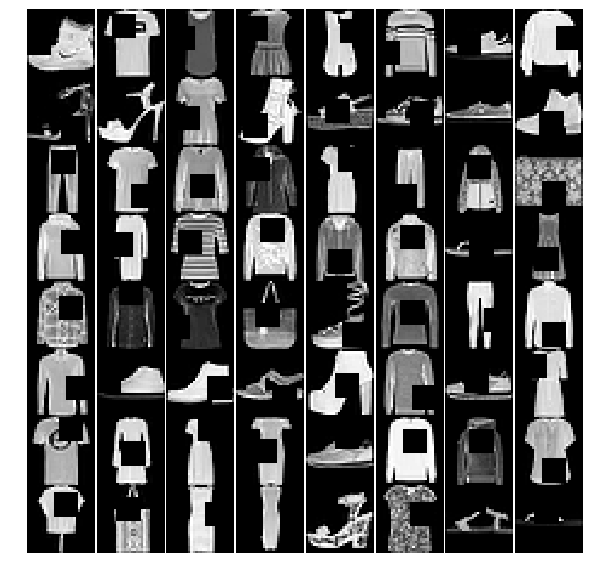

In [0]:
# Examples of lossy datasets
plt.figure(figsize = (10,10))
for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.imshow(bp_fmnist[i].data.numpy(), cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplots_adjust(wspace =0, hspace =0)

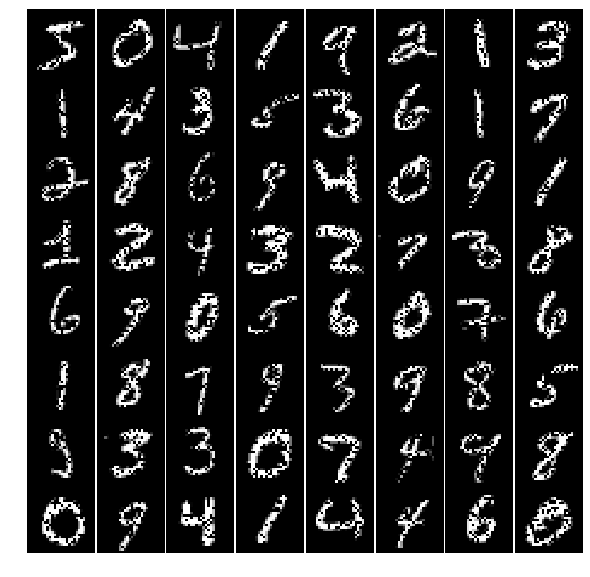

In [0]:
plt.figure(figsize = (10,10))
for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.imshow(bp_mnist[i].data.numpy(), cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplots_adjust(wspace =0, hspace =0)

In [0]:
# Dataloaders for lossy datasets
from torch.utils.data import TensorDataset
bp_mnist_dataset = TensorDataset(bp_mnist)
bp_mnist_dataloader = DataLoader(bp_mnist_dataset, batch_size = batch_size, shuffle=True)
bp_fmnist_dataset = TensorDataset(bp_fmnist)
bp_fmnist_dataloader = DataLoader(bp_fmnist_dataset, batch_size = batch_size, shuffle=True)

In [0]:
# Model and optimizer
amb_mnist_G = Generator()
amb_mnist_D = Discriminator()
amb_mnist_optim_G = torch.optim.Adam(amb_mnist_G.parameters(), lr=lr, betas=(b1, b2))
amb_mnist_optim_D = torch.optim.Adam(amb_mnist_D.parameters(), lr=lr, betas=(b1, b2))
if cuda:
    amb_mnist_G.cuda()
    amb_mnist_D.cuda()

In [0]:
# training function for AmbientGAN
def amb_train(generator, discriminator, n_epochs, optimizer_G, optimizer_D, dataloader, measurement, *args):
    d_loss_lst = []
    g_loss_lst = []
    
    generator.train()
    discriminator.train()
    for epoch in range(n_epochs):
        for i, imgs in enumerate(dataloader):

            # Configure input
            real_imgs = Variable(imgs[0].type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs[0].size(0), latent_dim))))

            # Generate a batch of images
            fake_imgs = generator(z)
            
            # Apply lossy measurement on generated images
            fake_measurements = measurement(fake_imgs, args[0])

            # Real images
            real_validity = discriminator(real_imgs)
            # Fake images
            fake_validity = discriminator(fake_measurements)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data.unsqueeze(1), fake_measurements.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # Train the generator every n_critic steps
            if i % n_critic == 0:

                # -----------------
                #  Train Generator
                # -----------------

                # Generate a batch of images
                fake_imgs = generator(z)
                
                # Apply lossy measurement on generated images
                fake_measurements = measurement(fake_imgs, args[0])
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = discriminator(fake_measurements)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optimizer_G.step()

        print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, d_loss.item(), g_loss.item()))
        d_loss_lst.append(d_loss.item())
        g_loss_lst.append(g_loss.item())
    return({'d_loss': d_loss_lst, 'g_loss': g_loss_lst})
    

In [0]:
# training function for original GAN
def basic_train(generator, discriminator, n_epochs, optimizer_G, optimizer_D, dataloader):
    d_loss_lst = []
    g_loss_lst = []
    
    generator.train()
    discriminator.train()
    for epoch in range(n_epochs):
        for i, imgs in enumerate(dataloader):

            # Configure input
            real_imgs = Variable(imgs[0].type(Tensor))

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Sample noise as generator input
            z = Variable(Tensor(np.random.normal(0, 1, (imgs[0].size(0), latent_dim))))

            # Generate a batch of images
            fake_imgs = generator(z)

            # Real images
            real_validity = discriminator(real_imgs)
            # Fake images
            fake_validity = discriminator(fake_imgs)
            # Gradient penalty
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data.unsqueeze(1), fake_imgs.data)
            # Adversarial loss
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

            d_loss.backward()
            optimizer_D.step()

            optimizer_G.zero_grad()

            # Train the generator every n_critic steps
            if i % n_critic == 0:

                # -----------------
                #  Train Generator
                # -----------------

                # Generate a batch of images
                fake_imgs = generator(z)
                # Loss measures generator's ability to fool the discriminator
                # Train on fake images
                fake_validity = discriminator(fake_imgs)
                g_loss = -torch.mean(fake_validity)

                g_loss.backward()
                optimizer_G.step()

        print("[Epoch %d/%d] [D loss: %f] [G loss: %f]" % (epoch, n_epochs, d_loss.item(), g_loss.item()))
        d_loss_lst.append(d_loss.item())
        g_loss_lst.append(g_loss.item())
    return({'d_loss': d_loss_lst, 'g_loss': g_loss_lst})
    

In [0]:
# train AmbientGAN for MNIST with Block-Pixels (p=0.3)
amb_mnist_loss = amb_train(amb_mnist_G, amb_mnist_D, n_epochs, amb_mnist_optim_G, amb_mnist_optim_D, bp_mnist_dataloader, block_pixels, 0.3)

[Epoch 0/200] [D loss: -7.559976] [G loss: -20.855083]
[Epoch 1/200] [D loss: -7.524462] [G loss: -20.728619]
[Epoch 2/200] [D loss: -7.261495] [G loss: -21.204098]
[Epoch 3/200] [D loss: -8.055145] [G loss: -20.682373]
[Epoch 4/200] [D loss: -8.440230] [G loss: -20.011353]
[Epoch 5/200] [D loss: -8.480394] [G loss: -19.020000]
[Epoch 6/200] [D loss: -8.684546] [G loss: -19.223083]
[Epoch 7/200] [D loss: -8.198168] [G loss: -20.157360]
[Epoch 8/200] [D loss: -8.522558] [G loss: -19.655632]
[Epoch 9/200] [D loss: -8.723266] [G loss: -19.756680]
[Epoch 10/200] [D loss: -8.601675] [G loss: -20.262787]
[Epoch 11/200] [D loss: -8.310051] [G loss: -20.610409]
[Epoch 12/200] [D loss: -8.794947] [G loss: -19.633644]
[Epoch 13/200] [D loss: -9.098310] [G loss: -19.693186]
[Epoch 14/200] [D loss: -9.018797] [G loss: -19.636082]
[Epoch 15/200] [D loss: -8.674242] [G loss: -20.277542]
[Epoch 16/200] [D loss: -9.378163] [G loss: -19.405415]
[Epoch 17/200] [D loss: -8.766239] [G loss: -18.655624]
[E

In [0]:
# Model and optimizer
mnist_G = Generator()
mnist_D = Discriminator()
mnist_optim_G = torch.optim.Adam(mnist_G.parameters(), lr=lr, betas=(b1, b2))
mnist_optim_D = torch.optim.Adam(mnist_D.parameters(), lr=lr, betas=(b1, b2))
if cuda:
    mnist_G.cuda()
    mnist_D.cuda()

In [0]:
# train original GAN for MNIST with Block-Pixels (p=0.3)
mnist_loss = basic_train(mnist_G, mnist_D, n_epochs, mnist_optim_G, mnist_optim_D, bp_mnist_dataloader)

[Epoch 0/200] [D loss: -2.495919] [G loss: -3.979686]
[Epoch 1/200] [D loss: -3.754400] [G loss: -1.443506]
[Epoch 2/200] [D loss: -3.484033] [G loss: -3.857023]
[Epoch 3/200] [D loss: -3.355685] [G loss: -0.714786]
[Epoch 4/200] [D loss: -5.850132] [G loss: 9.742325]
[Epoch 5/200] [D loss: -5.580544] [G loss: 5.226357]
[Epoch 6/200] [D loss: -5.888019] [G loss: 3.078083]
[Epoch 7/200] [D loss: -6.511294] [G loss: 1.216760]
[Epoch 8/200] [D loss: -6.174608] [G loss: 0.061784]
[Epoch 9/200] [D loss: -5.861082] [G loss: 1.595970]
[Epoch 10/200] [D loss: -5.896781] [G loss: 1.679809]
[Epoch 11/200] [D loss: -6.235403] [G loss: 2.075442]
[Epoch 12/200] [D loss: -5.648985] [G loss: 1.025502]
[Epoch 13/200] [D loss: -5.857497] [G loss: 1.243366]
[Epoch 14/200] [D loss: -5.812867] [G loss: 1.794126]
[Epoch 15/200] [D loss: -5.585717] [G loss: 1.675530]
[Epoch 16/200] [D loss: -5.770998] [G loss: 1.655676]
[Epoch 17/200] [D loss: -5.129479] [G loss: 1.781418]
[Epoch 18/200] [D loss: -5.618532]

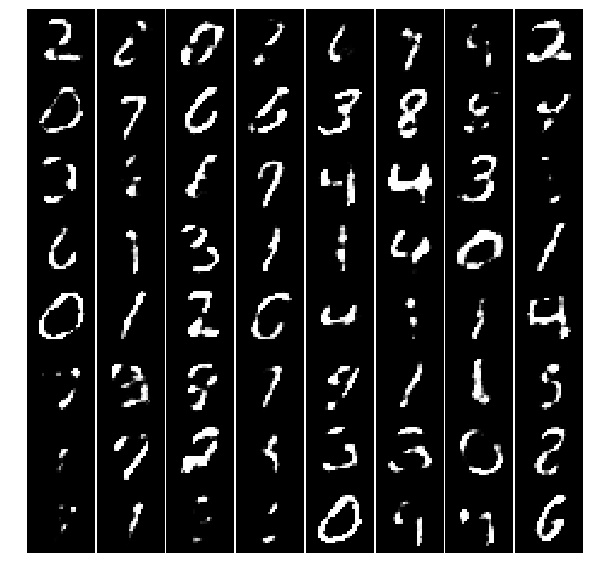

In [0]:
# Examples of AmbientGAN trained with MNIST
amb_mnist_G.eval()
inputs = torch.randn(batch_size, latent_dim).cuda()
amb_gen_images = amb_mnist_G(inputs)
plt.figure(figsize = (10,10))
import matplotlib.pyplot as plt
for i in range(amb_gen_images.shape[0]):
    plt.subplot(8,8,i+1)
    plt.imshow(amb_gen_images[i].cpu().data.numpy()[0], cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplots_adjust(wspace =0, hspace =0)

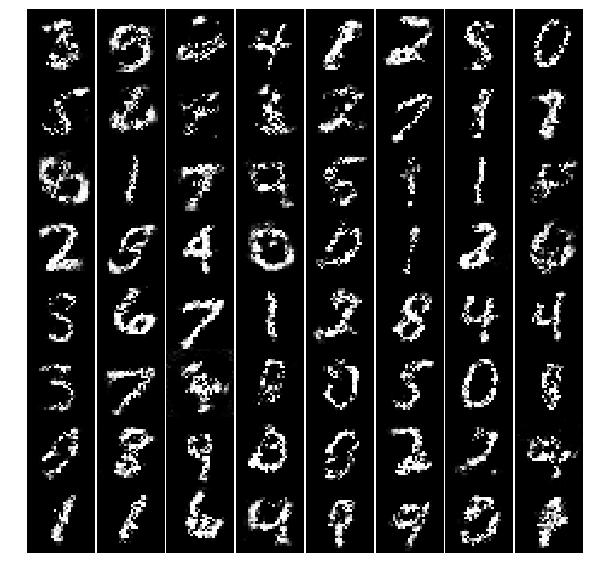

In [0]:
# Examples of original GAN trained with MNIST
mnist_G.eval()
gen_images = mnist_G(inputs)
plt.figure(figsize = (10,10))
import matplotlib.pyplot as plt
for i in range(gen_images.shape[0]):
    plt.subplot(8,8,i+1)
    plt.imshow(gen_images[i].cpu().data.numpy()[0], cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplots_adjust(wspace =0, hspace =0)

In [0]:
# train AmbientGAN for Fashion-MNIST with Block-Patches
amb_fmnist_G = Generator()
amb_fmnist_D = Discriminator()
amb_fmnist_optim_G = torch.optim.Adam(amb_fmnist_G.parameters(), lr=lr, betas=(b1, b2))
amb_fmnist_optim_D = torch.optim.Adam(amb_fmnist_D.parameters(), lr=lr, betas=(b1, b2))
if cuda:
    amb_fmnist_G.cuda()
    amb_fmnist_D.cuda()

In [0]:
amb_fmnist_loss = amb_train(amb_fmnist_G, amb_fmnist_D, n_epochs, amb_fmnist_optim_G, amb_fmnist_optim_D, bp_fmnist_dataloader, block_patches, 10)

[Epoch 0/200] [D loss: -7.782094] [G loss: 5.104987]
[Epoch 1/200] [D loss: -7.460491] [G loss: 0.920665]
[Epoch 2/200] [D loss: -5.328079] [G loss: 3.072692]
[Epoch 3/200] [D loss: -4.396499] [G loss: 2.430081]
[Epoch 4/200] [D loss: -5.534120] [G loss: 1.661479]
[Epoch 5/200] [D loss: -5.604651] [G loss: 0.490493]
[Epoch 6/200] [D loss: -4.805641] [G loss: 0.174600]
[Epoch 7/200] [D loss: -4.400765] [G loss: 0.454108]
[Epoch 8/200] [D loss: -3.581065] [G loss: 1.677711]
[Epoch 9/200] [D loss: -5.343639] [G loss: 1.439229]
[Epoch 10/200] [D loss: -3.856775] [G loss: 0.111374]
[Epoch 11/200] [D loss: -3.466342] [G loss: 2.179668]
[Epoch 12/200] [D loss: -3.949343] [G loss: -0.700511]
[Epoch 13/200] [D loss: -4.260192] [G loss: 0.065420]
[Epoch 14/200] [D loss: -3.714409] [G loss: 0.405062]
[Epoch 15/200] [D loss: -3.777453] [G loss: -0.541421]
[Epoch 16/200] [D loss: -4.834842] [G loss: 1.139128]
[Epoch 17/200] [D loss: -3.150490] [G loss: 0.521826]
[Epoch 18/200] [D loss: -3.214472] [

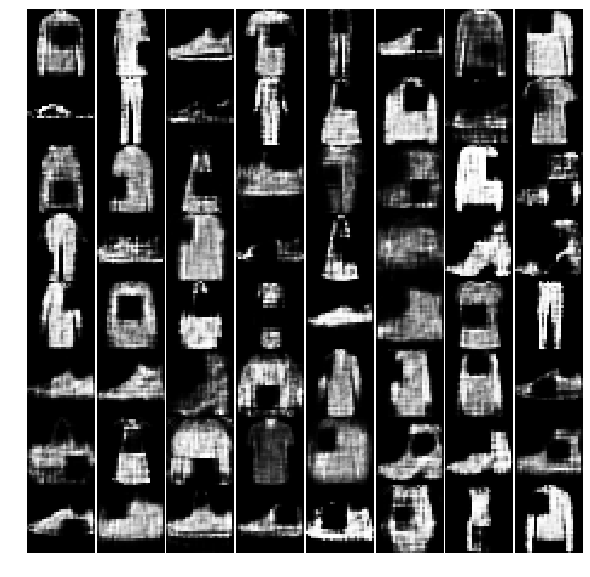

In [0]:
amb_fmnist_G.eval()
inputs = torch.randn(batch_size, latent_dim).cuda()
amb_gen_fimages = amb_fmnist_G(inputs)
plt.figure(figsize = (10,10))
import matplotlib.pyplot as plt
for i in range(amb_gen_fimages.shape[0]):
    plt.subplot(8,8,i+1)
    plt.imshow(amb_gen_fimages[i].cpu().data.numpy()[0], cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplots_adjust(wspace =0, hspace =0)

In [0]:
# # train original GAN for Fashion-MNIST with Block-Patches
fmnist_G = Generator()
fmnist_D = Discriminator()
fmnist_optim_G = torch.optim.Adam(fmnist_G.parameters(), lr=lr, betas=(b1, b2))
fmnist_optim_D = torch.optim.Adam(fmnist_D.parameters(), lr=lr, betas=(b1, b2))
if cuda:
    fmnist_G.cuda()
    fmnist_D.cuda()

In [0]:
fmnist_loss = basic_train(fmnist_G, fmnist_D, n_epochs, fmnist_optim_G, fmnist_optim_D, bp_fmnist_dataloader)

[Epoch 0/200] [D loss: -5.477235] [G loss: -4.306306]
[Epoch 1/200] [D loss: -6.714159] [G loss: 4.895077]
[Epoch 2/200] [D loss: -5.773149] [G loss: 2.006088]
[Epoch 3/200] [D loss: -6.289480] [G loss: 0.631012]
[Epoch 4/200] [D loss: -6.160076] [G loss: 2.563888]
[Epoch 5/200] [D loss: -6.743822] [G loss: 1.895827]
[Epoch 6/200] [D loss: -4.445197] [G loss: 1.045897]
[Epoch 7/200] [D loss: -5.492452] [G loss: -0.363904]
[Epoch 8/200] [D loss: -6.558877] [G loss: -0.422497]
[Epoch 9/200] [D loss: -5.103794] [G loss: 3.369274]
[Epoch 10/200] [D loss: -4.683335] [G loss: 1.226399]
[Epoch 11/200] [D loss: -4.615849] [G loss: -0.944008]
[Epoch 12/200] [D loss: -4.876118] [G loss: -0.699776]
[Epoch 13/200] [D loss: -3.672765] [G loss: -0.335695]
[Epoch 14/200] [D loss: -3.960931] [G loss: -1.406103]
[Epoch 15/200] [D loss: -4.739182] [G loss: 0.123133]
[Epoch 16/200] [D loss: -3.989225] [G loss: 0.124745]
[Epoch 17/200] [D loss: -3.974866] [G loss: 0.649772]
[Epoch 18/200] [D loss: -4.4528

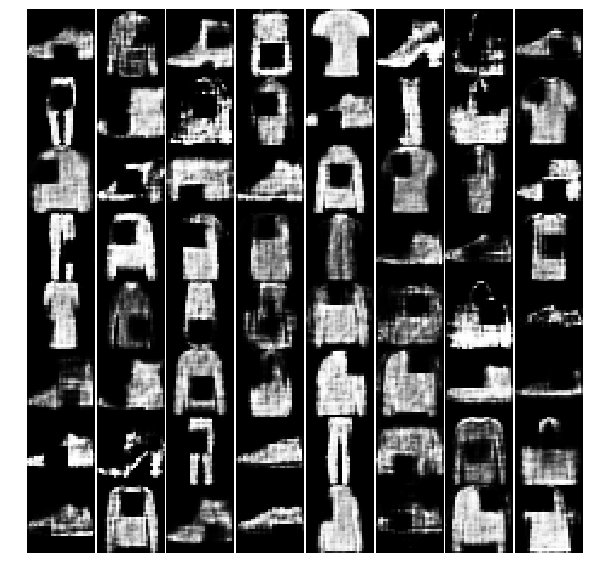

In [0]:
fmnist_G.eval()
gen_fimages = fmnist_G(inputs)
plt.figure(figsize = (10,10))
import matplotlib.pyplot as plt
for i in range(gen_fimages.shape[0]):
    plt.subplot(8,8,i+1)
    plt.imshow(gen_fimages[i].cpu().data.numpy()[0], cmap = plt.get_cmap('gray'))
    plt.axis('off')
    plt.subplots_adjust(wspace =0, hspace =0)

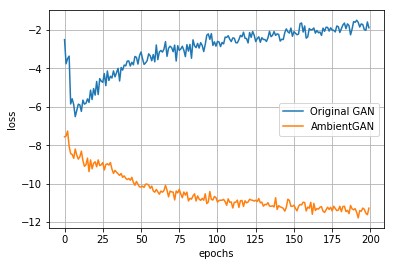

In [0]:
# plot discriminator loss vs epochs for mnist
plt.grid()
plt.plot(mnist_loss['d_loss'], label = 'Original GAN')
plt.plot(amb_mnist_loss['d_loss'], label = 'AmbientGAN')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

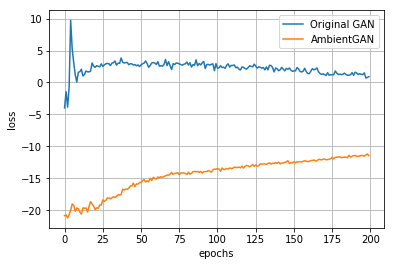

In [0]:
# plot generator loss vs epochs for mnist
plt.grid()
plt.plot(mnist_loss['g_loss'], label = 'Original GAN')
plt.plot(amb_mnist_loss['g_loss'], label = 'AmbientGAN')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

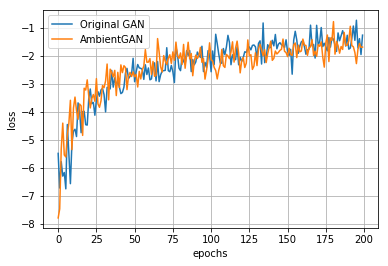

In [0]:
# plot discriminator loss vs epochs for Fashion-MNIST
plt.grid()
plt.plot(fmnist_loss['d_loss'], label = 'Original GAN')
plt.plot(amb_fmnist_loss['d_loss'], label = 'AmbientGAN')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

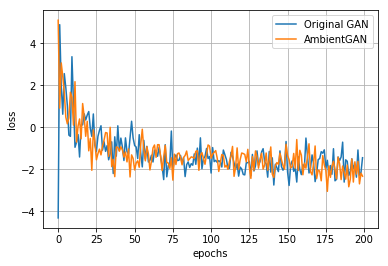

In [0]:
# plot generator loss vs epochs for Fashion-MNIST
plt.grid()
plt.plot(fmnist_loss['g_loss'], label = 'Original GAN')
plt.plot(amb_fmnist_loss['g_loss'], label = 'AmbientGAN')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()